In [1]:
import os
from google.cloud import storage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
BUCKET_NAME = "dsci471"
IMAGE_EXTENSIONS = ('.jpg', '.jpeg')
REORG_DATASET_PPREFIX = "reorg_80_10_10/"

In [3]:
storage_client = storage.Client.create_anonymous_client()

In [4]:
def count_image_files_in_gcs(bucket_name, prefix_path):
    count = 0
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix_path)
    
    for blob in blobs:
        if blob.name.lower().endswith(IMAGE_EXTENSIONS) and blob.name != prefix_path:
            count += 1
    return count

In [ ]:
original_data_counts = {}
original_kaggle_splits = ['train', 'val', 'test']
original_categories = ['NORMAL', 'PNEUMONIA']

total_original_files = 0

for kaggle_split in original_kaggle_splits:
    original_data_counts[kaggle_split] = {}
    for category in original_categories:
        path_parts = [part.strip('/') for part in [kaggle_split, category] if part.strip('/')]
        current_prefix = "/".join(path_parts) + "/"
        
        count = count_image_files_in_gcs(BUCKET_NAME, current_prefix)
        original_data_counts[kaggle_split][category] = count
        total_original_files += count

df_original_detailed = pd.DataFrame(original_data_counts).fillna(0).astype(int)
df_original_detailed.head()

,train,val,test
NORMAL,1341,8,234
PNEUMONIA,3875,8,390


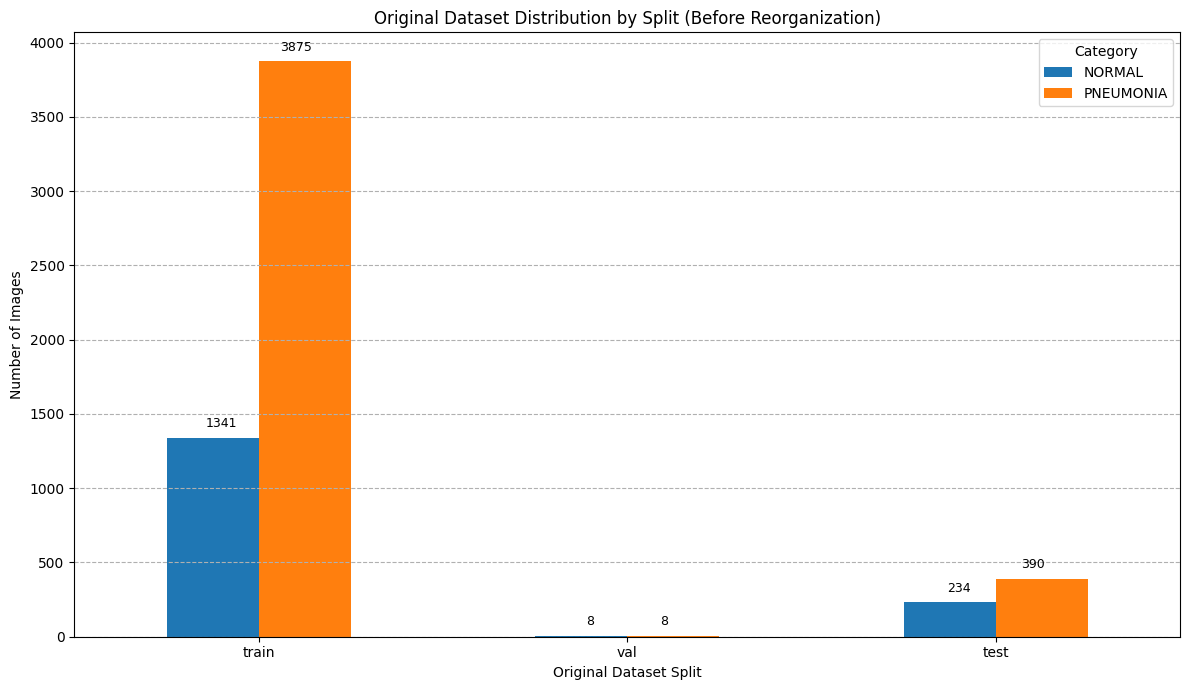

In [17]:
df_original_detailed.T.plot(kind='bar', figsize=(12, 7))
plt.title('Original Dataset Distribution by Split (Before Reorganization)')
plt.xlabel('Original Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--')

for i, r in enumerate(df_original_detailed.T.iterrows()):
    for j, val in enumerate(r[1]):
        if val > 0:
            plt.text(i + (j - 0.5) * 0.2 , val + 50, str(val), ha='center', va='bottom', fontsize=9)


plt.tight_layout()
plt.show()

In [9]:
reorganized_data_counts = {}
new_splits = ['train', 'val', 'test']
new_categories = ['NORMAL', 'PNEUMONIA_VIRAL', 'PNEUMONIA_BACTERIAL']

total_reorganized_files = 0

for split_type in new_splits:
    reorganized_data_counts[split_type] = {}
    for category in new_categories:
        path_parts = [part.strip('/') for part in [REORG_DATASET_PPREFIX, split_type, category] if part.strip('/')]
        current_prefix = "/".join(path_parts) + "/"
        
        count = count_image_files_in_gcs(BUCKET_NAME, current_prefix)
        reorganized_data_counts[split_type][category] = count
        total_reorganized_files += count

df_reorganized = pd.DataFrame(reorganized_data_counts).fillna(0).astype(int)
df_reorganized.head()

,train,val,test
NORMAL,1266,158,159
PNEUMONIA_VIRAL,1194,149,150
PNEUMONIA_BACTERIAL,2224,278,278


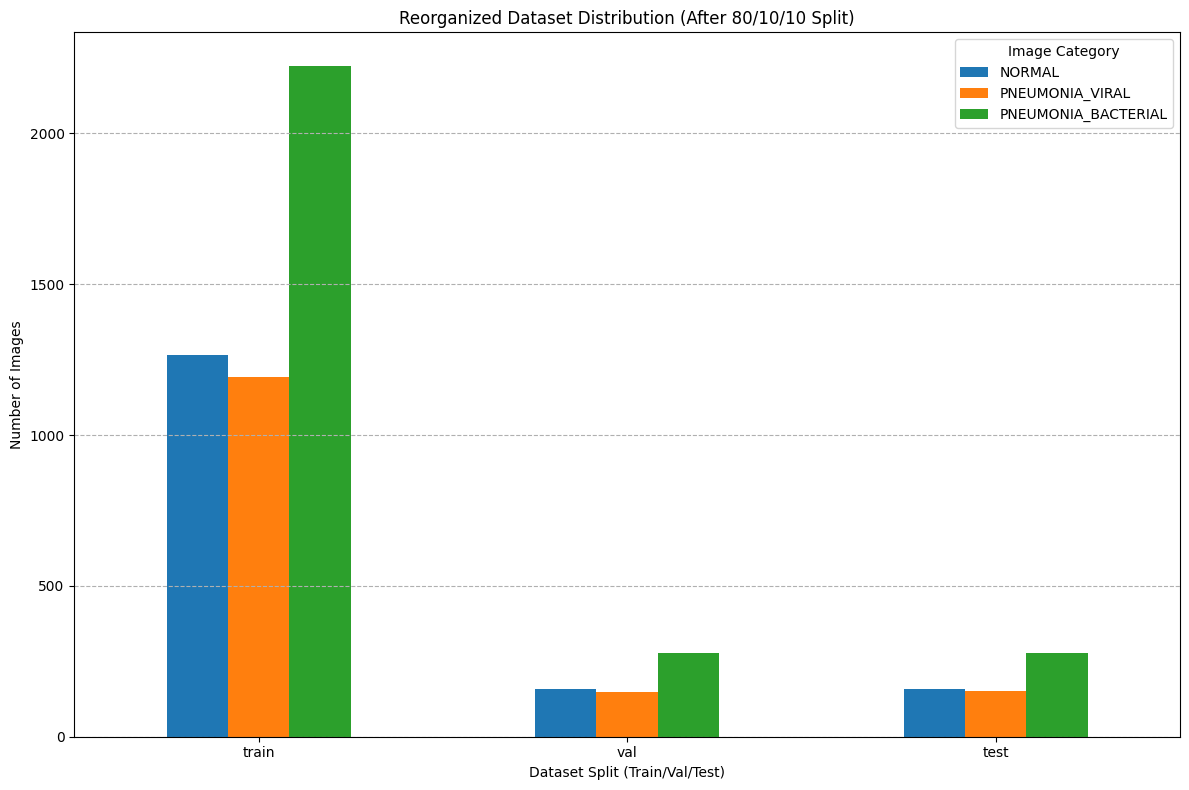

In [37]:
df_reorganized.T.plot(kind='bar', figsize=(12, 8))
plt.title('Reorganized Dataset Distribution (After 80/10/10 Split)')
plt.xlabel('Dataset Split (Train/Val/Test)')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(title='Image Category')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
import io
import random
from collections import defaultdict
from PIL import Image, ImageStat
from skimage import color

In [6]:
def download_image_as_pil(blob):
    try:
        image_bytes = blob.download_as_bytes()
        image = Image.open(io.BytesIO(image_bytes))
        return image
    except Exception as e:
        print(f"Error downloading or opening image {blob.name}: {e}")
        return None

In [7]:
def list_image_blobs_from_gcs(bucket_name, prefix_path):    
    bucket = storage_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=prefix_path))
    
    image_blobs = [
        blob for blob in blobs 
        if blob.name.lower().endswith(IMAGE_EXTENSIONS) and blob.name != prefix_path
    ]
    
    return image_blobs

In [45]:
dimension_data = []

for split in new_splits:
    for category in new_categories:
        current_prefix = f"{REORG_DATASET_PPREFIX}{split}/{category}/"
        
        sample_blobs = list_image_blobs_from_gcs(
            BUCKET_NAME, 
            current_prefix, 
        )
            
        sample = random.sample(sample_blobs, min(500, len(sample_blobs)))
        for blob in sample:
            img = download_image_as_pil(blob)
            if img:
                width, height = img.size
                aspect_ratio = width / height if height > 0 else 0
                dimension_data.append({
                    'split': split,
                    'category': category,
                    'filename': blob.name.split('/')[-1],
                    'width': width,
                    'height': height,
                    'aspect_ratio': aspect_ratio,
                    'mode': img.mode 
                })

In [47]:
df_dimensions = pd.DataFrame(dimension_data)
print(f"\nCollected dimension data for {len(df_dimensions)} images.")
print(df_dimensions.head())


Collected dimension data for 2672 images.
   split category                   filename  width  height  aspect_ratio mode
0  train   NORMAL  NORMAL2-IM-0282-0001.jpeg   2667    2280      1.169737    L
1  train   NORMAL          IM-0304-0001.jpeg   1472     978      1.505112    L
2  train   NORMAL          IM-0277-0001.jpeg   1608    1345      1.195539    L
3  train   NORMAL     IM-0539-0001-0001.jpeg   2110    1700      1.241176    L
4  train   NORMAL          IM-0678-0001.jpeg   1792    1611      1.112353    L


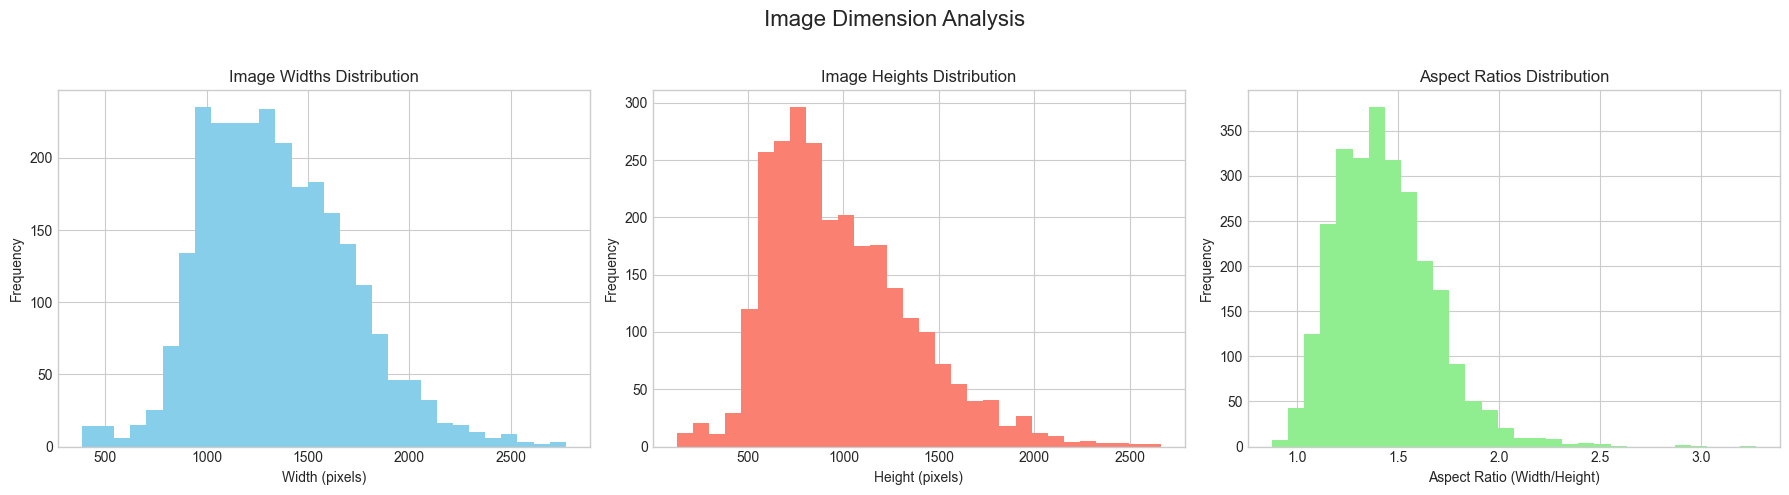

In [48]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df_dimensions['width'].plot(kind='hist', bins=30, ax=axes[0], title='Image Widths Distribution', color='skyblue')
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Frequency")

df_dimensions['height'].plot(kind='hist', bins=30, ax=axes[1], title='Image Heights Distribution', color='salmon')
axes[1].set_xlabel("Height (pixels)")

df_dimensions['aspect_ratio'].plot(kind='hist', bins=30, ax=axes[2], title='Aspect Ratios Distribution', color='lightgreen')
axes[2].set_xlabel("Aspect Ratio (Width/Height)")

plt.suptitle('Image Dimension Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

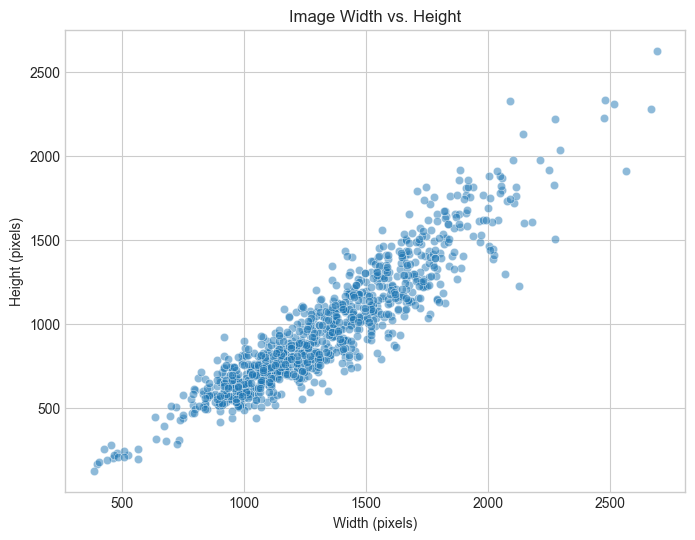

In [49]:
plt.figure(figsize=(8, 6))
sample_for_scatter = df_dimensions.sample(min(1000, len(df_dimensions))) 
plt.scatter(sample_for_scatter['width'], sample_for_scatter['height'], alpha=0.5, edgecolors='w', linewidth=0.5)
plt.title('Image Width vs. Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()

In [50]:
print("\nSummary statistics for dimensions:")
print(df_dimensions[['width', 'height', 'aspect_ratio']].describe())


Summary statistics for dimensions:
             width       height  aspect_ratio
count  2672.000000  2672.000000   2672.000000
mean   1348.177395   987.194611      1.438303
std     361.394122   380.990368      0.249664
min     384.000000   127.000000      0.877220
25%    1080.000000   704.000000      1.256098
50%    1312.000000   912.000000      1.411163
75%    1584.000000  1216.000000      1.584538
max    2772.000000  2663.000000      3.271523


reorg_80_10_10/train/NORMAL/
<Blob: dsci471, reorg_80_10_10/train/NORMAL/NORMAL2-IM-0374-0001-0002.jpeg, 1746912227778462>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/IM-0166-0001.jpeg, 1746912257026471>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/IM-0384-0001.jpeg, 1746912236892279>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/IM-0482-0001.jpeg, 1746912262084045>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/NORMAL2-IM-0305-0001.jpeg, 1746912268908598>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/NORMAL2-IM-1041-0001.jpeg, 1746912232103053>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/IM-0647-0001.jpeg, 1746912278272505>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/NORMAL2-IM-0600-0001.jpeg, 1746912254278699>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/IM-0644-0001.jpeg, 1746912228229528>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/IM-0591-0001.jpeg, 1746912271984089>
<Blob: dsci471, reorg_80_10_10/train/NORMAL/NORMAL2-IM-1142-0001.jpeg, 1746912267910233>
<Blob: dsci471, reorg_80_10_10/trai

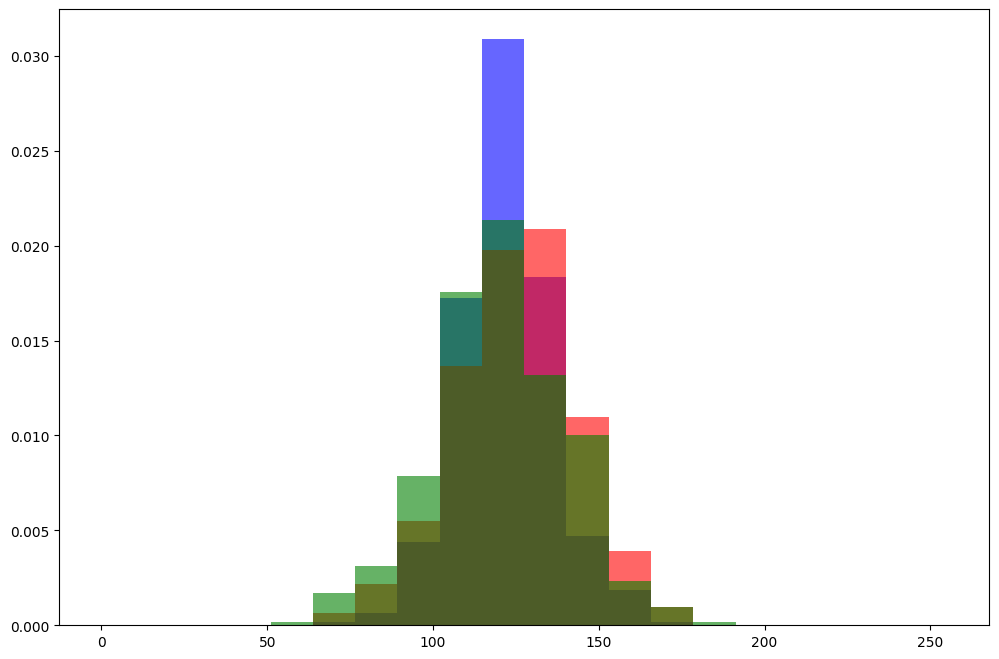

In [ ]:
plt.figure(figsize=(12, 8))
colors = {'NORMAL': 'blue', 'PNEUMONIA_VIRAL': 'red', 'PNEUMONIA_BACTERIAL': 'green'}
all_mean_intensities_by_category = defaultdict(list)


for category in new_categories:
    current_prefix = f"{REORG_DATASET_PPREFIX}train/{category}/" 
    print(current_prefix)
    
    sample_blobs = list_image_blobs_from_gcs(
        BUCKET_NAME, 
        current_prefix, 
    )
    
    category_mean_intensities = []

    sample = random.sample(sample_blobs, min(500, len(sample_blobs)))
    for blob in sample:
        print(blob)
        img = download_image_as_pil(blob)
        if img:
            grayscale_img = img.convert('L') 
            mean_intensity = np.array(grayscale_img).mean()
            category_mean_intensities.append(mean_intensity)
            
    all_mean_intensities_by_category[category] = category_mean_intensities


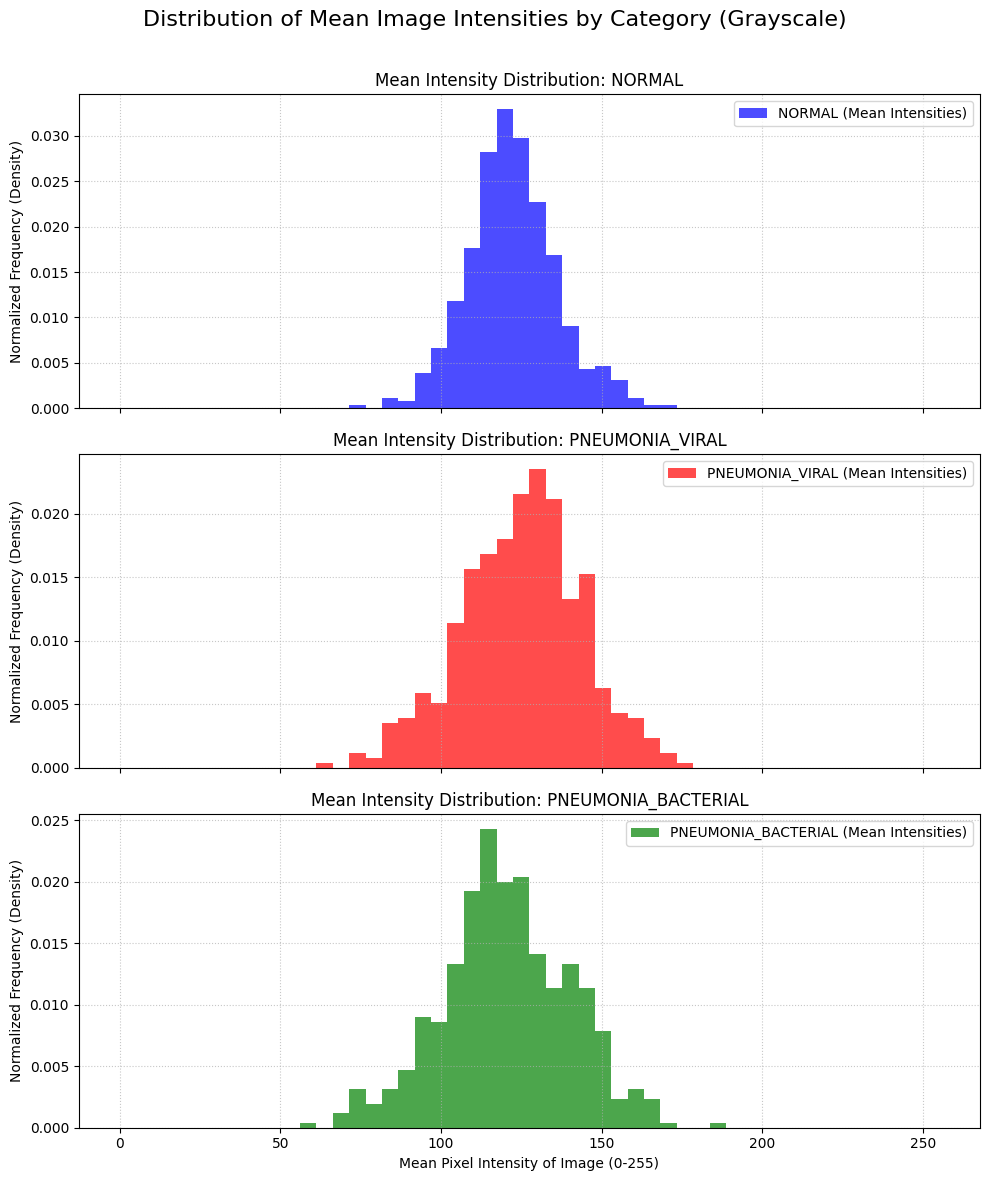

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(10, 4 * 3), sharex=True)

plot_idx = 0
for category_idx, category_name in enumerate(new_categories):
    means = all_mean_intensities_by_category[category_name]
    ax = axes[plot_idx]
    ax.hist(means, bins=50, range=(0,255), density=True, 
                alpha=0.7, label=f"{category_name} (Mean Intensities)", 
                color=colors.get(category_name, 'gray'))
    ax.set_title(f"Mean Intensity Distribution: {category_name}")
    ax.set_ylabel('Normalized Frequency (Density)')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend(loc='upper right')
    plot_idx += 1


axes[-1].set_xlabel('Mean Pixel Intensity of Image (0-255)')

fig.suptitle('Distribution of Mean Image Intensities by Category (Grayscale)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [25]:
print("\nSummary of Mean Image Intensities per Category:")
for category, means in all_mean_intensities_by_category.items():
    print(f"  Category: {category}")
    print(f"    Count: {len(means)}")
    print(f"    Min Mean: {np.min(means):.2f}")
    print(f"    Avg Mean: {np.mean(means):.2f}")
    print(f"    Max Mean: {np.max(means):.2f}")
    print(f"    Std Dev: {np.std(means):.2f}")


Summary of Mean Image Intensities per Category:
  Category: NORMAL
    Count: 500
    Min Mean: 73.30
    Avg Mean: 122.14
    Max Mean: 168.39
    Std Dev: 13.87
  Category: PNEUMONIA_VIRAL
    Count: 500
    Min Mean: 66.25
    Avg Mean: 124.90
    Max Mean: 175.19
    Std Dev: 18.71
  Category: PNEUMONIA_BACTERIAL
    Count: 500
    Min Mean: 60.69
    Avg Mean: 120.32
    Max Mean: 184.17
    Std Dev: 20.02
